# **FEATURE EXTRACTION - BAG OF WORDS**

In [30]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable
from pprint import pprint

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel, LdaMulticore

from nltk import FreqDist

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [13]:
#set seed so that code output is deterministic
random.seed(1)  # Set the seed for Python's random module
np.random.seed(1)  # Set the seed for NumPy's random module

## **CREATE CORPUS AND BOW REPRESENTATION**

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('../Data/training_data.csv', converters ={'tokens':list_converter})
data = data.drop(columns = ['index'])
data.head()

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
0,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel past,"[single, travel, past]",3
1,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...,shop dragon mart,"[shop, dragon, mart]",3
2,comment,gthiiwi,2021-04-05 23:18:56,2021,"That’s just absolutely hilarious, is this in t...",hilarious spring souk,"[hilarious, spring, souk]",3
3,comment,gtgfl4c,2021-04-05 18:21:42,2021,Is reel cinema and roxy part of emaar?,reel cinema roxy emaar,"[reel, cinema, roxy, emaar]",4
4,comment,gth5wdv,2021-04-05 21:42:41,2021,An innocent redditor here...can someone pls ex...,innocent pls explain everyday,"[innocent, pls, explain, everyday]",4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65987 entries, 0 to 65986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     65987 non-null  object
 1   ID            65987 non-null  object
 2   date_created  65987 non-null  object
 3   year          65987 non-null  int64 
 4   long_text     65987 non-null  object
 5   clean_text    65987 non-null  object
 6   tokens        65987 non-null  object
 7   word_count    65987 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.0+ MB


In [5]:
#convert df['tokens'] to list of strings for bag-of-words model
docs = data['tokens'].tolist()

docs[0:5]

[['single', 'travel', 'past'],
 ['shop', 'dragon', 'mart'],
 ['hilarious', 'spring', 'souk'],
 ['reel', 'cinema', 'roxy', 'emaar'],
 ['innocent', 'pls', 'explain', 'everyday']]

In [6]:
#check number of unique words

unique_words = set([word for text in docs for word in text])

print (f'There are {len(unique_words)} unique words in the dataset')


There are 7577 unique words in the dataset


In [7]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2023-08-10 14:07:31,095 : INFO : collecting all words and their counts
2023-08-10 14:07:31,098 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-08-10 14:07:31,308 : INFO : PROGRESS: at sentence #10000, processed 91769 words and 77987 word types
2023-08-10 14:07:31,544 : INFO : PROGRESS: at sentence #20000, processed 184149 words and 144024 word types
2023-08-10 14:07:31,864 : INFO : PROGRESS: at sentence #30000, processed 273142 words and 203298 word types
2023-08-10 14:07:32,110 : INFO : PROGRESS: at sentence #40000, processed 366079 words and 263847 word types
2023-08-10 14:07:32,341 : INFO : PROGRESS: at sentence #50000, processed 458631 words and 321458 word types
2023-08-10 14:07:32,696 : INFO : PROGRESS: at sentence #60000, processed 547886 words and 374811 word types
2023-08-10 14:07:32,951 : INFO : collected 422480 token types (unigram + bigrams) from a corpus of 629542 words and 65987 sentences
2023-08-10 14:07:32,956 : INFO : merged Phrases<422480 vo

In [8]:
print(docs[200])

['labor', 'law', 'common', 'blatant', 'sale', 'promotional', 'hire', 'filter', 'rife', 'real', 'estate', 'industry', 'young', 'motivation', 'law', 'align', 'progressive', 'practice', 'nature', 'labor_law', 'real_estate']


In [11]:
#from gensim bag of words documentation page

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

2023-08-10 14:08:02,935 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-08-10 14:08:03,375 : INFO : adding document #10000 to Dictionary<7146 unique tokens: ['past', 'single', 'travel', 'dragon', 'dragon_mart']...>
2023-08-10 14:08:03,767 : INFO : adding document #20000 to Dictionary<7682 unique tokens: ['past', 'single', 'travel', 'dragon', 'dragon_mart']...>
2023-08-10 14:08:04,133 : INFO : adding document #30000 to Dictionary<7795 unique tokens: ['past', 'single', 'travel', 'dragon', 'dragon_mart']...>
2023-08-10 14:08:04,416 : INFO : adding document #40000 to Dictionary<7846 unique tokens: ['past', 'single', 'travel', 'dragon', 'dragon_mart']...>
2023-08-10 14:08:04,683 : INFO : adding document #50000 to Dictionary<7861 unique tokens: ['past', 'single', 'travel', 'dragon', 'dragon_mart']...>
2023-08-10 14:08:04,934 : INFO : adding document #60000 to Dictionary<7872 unique tokens: ['past', 'single', 'travel', 'dragon', 'dragon_mart']...>
2023-08-10 14:08:05,146 :

Number of unique tokens: 5000
Number of documents: 65987


## **TRAIN LDA MODEL**

In [ ]:

#from gensim documentation at https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?expand_article=1#9createbigramandtrigrammodels
#https://github.com/clevyclev/Deep-Learning-Projects/blob/master/Latent%20Dirichlet%20Allocation%20-%20Bag%20of%20Words%20and%20TF-IDF/Latent_dirichlet_allocation.py

#training parameters
#num_topics = 9
chunksize = 5000
passes = 10
iterations = 400
eval_every = None
id2word = dictionary.id2token
temp = dictionary[0] #to "load" the dictionary

#range of topics
topics_range = range (2,20,2)

#list to hold coherence value
model_coherence = []

for num_topics in topics_range:
    
    #train LDA model
    lda_model = LdaModel(corpus = corpus,
                             id2word = dictionary,
                             chunksize = chunksize,
                             alpha = 'auto',
                             eta = 'auto',
                             passes = passes,
                             #iterations = iterations,
                             num_topics = num_topics,
                             per_word_topics = True,
                             random_state = 100,
                            )
    #compute coherence score
    coherence_model_lda = CoherenceModel (model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_v' )
    coherence_lda = coherence_model_lda.get_coherence()
    model_coherence.append(coherence_lda)

#plot coherence scores

plt.plot(topics_range, model_coherence)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('Coherence Score vs. Number of Topics')

plt.show()

2023-08-10 14:24:58,556 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2023-08-10 14:24:58,564 : INFO : using serial LDA version on this node
2023-08-10 14:24:58,567 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 65987 documents, updating model once every 5000 documents, evaluating perplexity every 50000 documents, iterating 50x with a convergence threshold of 0.001000
2023-08-10 14:24:58,570 : INFO : PROGRESS: pass 0, at document #5000/65987
2023-08-10 14:25:01,604 : INFO : optimized alpha [0.68210006, 0.69499624]
2023-08-10 14:25:01,606 : INFO : merging changes from 5000 documents into a model of 65987 documents
2023-08-10 14:25:01,608 : INFO : topic #0 (0.682): 0.006*"buy" + 0.005*"cost" + 0.005*"price" + 0.004*"delivery" + 0.004*"salary" + 0.004*"parent" + 0.004*"drive" + 0.004*"service" + 0.004*"language" + 0.004*"rent"
2023-08-10 14:25:01,610 : INFO : topic #1 (0.695): 0.005*"property" + 0.005*"buy" + 0.005*"language" 

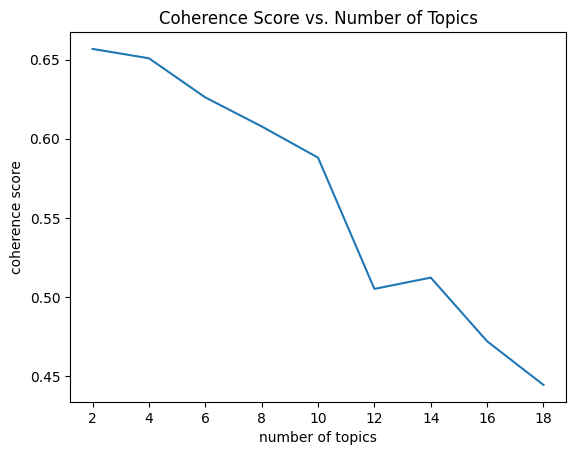

In [21]:
#plot coherence scores

plt.plot(topics_range, model_coherence)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('Coherence Score vs. Number of Topics')

plt.show()

In [37]:

#from gensim documentation at https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?expand_article=1#9createbigramandtrigrammodels
#https://github.com/clevyclev/Deep-Learning-Projects/blob/master/Latent%20Dirichlet%20Allocation%20-%20Bag%20of%20Words%20and%20TF-IDF/Latent_dirichlet_allocation.py

#training parameters
num_topics = 10
chunksize = 5000
passes = 10
iterations = 400
eval_every = None
id2word = dictionary.id2token
temp = dictionary[0] #to "load" the dictionary




    
#train LDA model
lda_model = LdaModel(corpus = corpus,
                             id2word = dictionary,
                             chunksize = chunksize,
                             #alpha = 'auto',
                             #eta = 'auto',
                             passes = passes,
                             iterations = iterations,
                             num_topics = num_topics,
                             per_word_topics = True,
                             random_state = 100,
                            )

2023-08-10 19:05:55,608 : INFO : using symmetric alpha at 0.1
2023-08-10 19:05:55,614 : INFO : using symmetric eta at 0.1
2023-08-10 19:05:55,627 : INFO : using serial LDA version on this node
2023-08-10 19:05:55,650 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 65987 documents, updating model once every 5000 documents, evaluating perplexity every 50000 documents, iterating 400x with a convergence threshold of 0.001000
2023-08-10 19:05:55,769 : INFO : PROGRESS: pass 0, at document #5000/65987
2023-08-10 19:05:58,911 : INFO : merging changes from 5000 documents into a model of 65987 documents
2023-08-10 19:05:58,916 : INFO : topic #1 (0.100): 0.008*"card" + 0.007*"building" + 0.006*"property" + 0.006*"buy" + 0.005*"offer" + 0.005*"visa" + 0.005*"stop" + 0.005*"area" + 0.005*"safe" + 0.005*"drive"
2023-08-10 19:05:58,917 : INFO : topic #6 (0.100): 0.009*"language" + 0.008*"price" + 0.007*"indian" + 0.006*"india" + 0.005*"family" + 0.0

In [41]:
#check coherence and perplexity

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2023-08-10 20:16:44,789 : INFO : -7.996 per-word bound, 255.2 perplexity estimate based on a held-out corpus of 65987 documents with 603838 words
2023-08-10 20:16:44,798 : INFO : using ParallelWordOccurrenceAccumulator<processes=3, batch_size=64> to estimate probabilities from sliding windows



Perplexity:  -7.995673397983394


2023-08-10 20:16:53,392 : INFO : 3 accumulators retrieved from output queue
2023-08-10 20:16:53,445 : INFO : accumulated word occurrence stats for 75046 virtual documents



Coherence Score:  0.5983188708327412


## **VISUALIZE TOPICS**

In [2]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

NameError: name 'pprint' is not defined

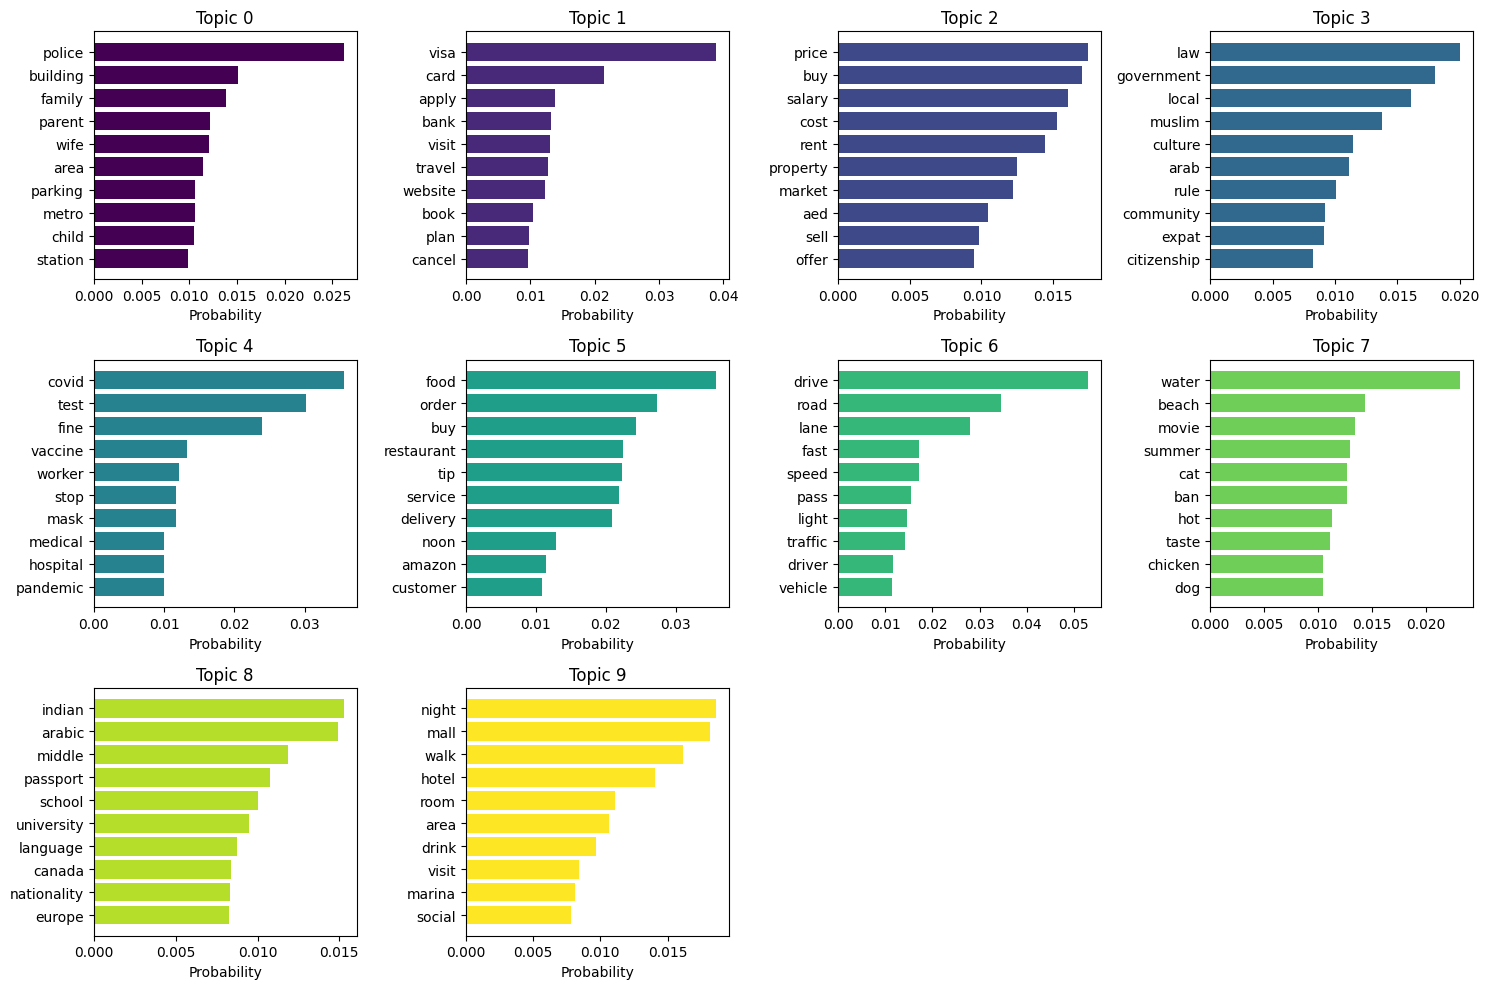

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#number of topics
num_topics = lda_model.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 3
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(15,10))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = lda_model.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [1]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

NameError: name 'pyLDAvis' is not defined

In [49]:
#top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
#avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
#print('Average topic coherence: %.4f.' % avg_topic_coherence)


#pprint(top_topics)

## **SAVE TRAINED MODEL**

In [34]:
#lda_model.save('lda_model_1')

In [45]:
#save model parameters

#model_1

model1_params = {
    
    'model1_corpus_params': {
        'phrases_min_count': 20,
        'corpus': {
            'no_below': 20,
            'no_above': 0.5
        }
    },
    
    'model1_training_params':{
        'num_topics': 10,
        'chunksize': 5000,
        'passes': 10,
        'eval_every': None,
        'id2word': dictionary.id2token,
        'alpha': 'auto',
        'eta': 'auto',
        'per_word_topics': 'True',
        'random_state': 100
    }
}

import json
with open ('model1_params', 'w') as file:
    json.dump(model1_params, file)